# Chapter 4 | Natural Language Processing, Transformers, Huggingface
> A New Library, New Model Architectures, And Natural Language Data
>Checkout this notebook in [colab](https://colab.research.google.com/github/nglillywhite/blog/blob/main/posts/wotwot)

This week focuses on building models with interact with natural language which is very different from images or structured tabular data. Jeremy starts off discussing some model architectures (some of which he pioneered with collaborators) like 'ULMFit', 'Transformers', and Recurrent Neural Nets (RNNs) which are often seen in the news headlines as being significant. This week will also use huggingface, which is another library from fastai but is seemingly the best library as of writing this for working with language. We're going to dive into tokenising and other natural language specific problems.

## Lecture Content
### US Patent Phrase Matching

We're working with the [US Patent Phrase Matching](https://www.kaggle.com/competitions/us-patent-phrase-to-phrase-matching) Kaggle Competition data for this lesson lecture, I've just visited the page and downloaded the dataset into my local data path but you can of course use the kaggle APIs.

This competition in particular is about comparing two short phrases and whether they are similar to each other based on which patent class they were used with. Scores of 1 being identical and 0 meaning they are different. The scores are represented in a set of 0, 0.25, 0.5, and 1 which acts like a classification problem rather than regression because they're distinct instead of smooth.

Jeremy starts by proposing that we can feed this into our model successfully by representing the data as "TEXT1: abatement; TEXT2: eliminating process" of which we then pick a distinct category from the above. To my understand this relates to the 'anchors' and 'target' in this dataset which we'll look at below.

### EDA of Patent Data

In [1]:
from pathlib import Path
from fastai.vision.all import *

data_path = Path("../data/us-patent-phrase-to-matching/")

In [2]:
data_path.ls()

(#2) [Path('../data/us-patent-phrase-to-matching/test.csv'),Path('../data/us-patent-phrase-to-matching/train.csv')]

In [3]:
import pandas as pd

df = pd.read_csv(data_path / "train.csv")

df.head()

,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00


In [4]:
df.describe(include="object")

,id,anchor,target,context
count,36473,36473,36473,36473
unique,36473,733,29340,106
top,37d61fd2272659b1,component composite coating,composition,H01
freq,1,152,24,2186


From having a quick look at a data sample and a description of the dataframe itself, there simply aren't that many unique contexts or anchors, and the anchor 'component composite coating' turns up 152 times which seems like a lot our of the 733 total.

Lets now build our first feature which will be the 'input' feature. We'll structure this feature as we noted earlier in the TEXT1: ...; TEXT2:...; format

In [5]:
df['input'] = "TEXT1: " + df.context + "; TEXT2: " + df.target + "; ANC1: " + df.anchor

df.input.head()

0    TEXT1: A47; TEXT2: abatement of pollution; ANC1: abatement
1            TEXT1: A47; TEXT2: act of abating; ANC1: abatement
2           TEXT1: A47; TEXT2: active catalyst; ANC1: abatement
3       TEXT1: A47; TEXT2: eliminating process; ANC1: abatement
4             TEXT1: A47; TEXT2: forest region; ANC1: abatement
Name: input, dtype: object

Ok this looks great, I'm already a bit confused since the dataset has described the df.context as the CPC classification subject and the anchor and target being the first and second phrase respectively whereas Jeremy has put the context as the first text. Nonethless, I'm sure the naming of each of these features is sort of irrelevant as long as its consistent. If I called it 'text1' or 'feature1' or 'f1' it wouldn't matter to the model, its all matrices in the end.


### Tokenisation and Numericalisation
Lets now take on the first two new topics which are tokenisation and numericalisation, this is the act of transforming our words into tokens which represent unique examples of words and turning those tokens into numbers which we can then matrix multiply and then convert back after the fact. We're going to use huggingface's datasets library and use their "Dataset" class which overlaps a class name with fastai and pytorch.

In [6]:
from datasets import Dataset, DatasetDict

ds = Dataset.from_pandas(df)

ds

Dataset({
    features: ['id', 'anchor', 'target', 'context', 'score', 'input'],
    num_rows: 36473
})

Ok not learning a huge amount from the output but it at least lets us know what our features are and how many rows we have.

In [7]:
doc(Dataset)

Doesn't tell me a whole lot about the class or purpose but lets move on for now.

An important thing to note is that particular tokenisers are used for particular models and if you want to use a pre-trained model, you have to make sure you have the same tokeniser (and numericalisation process) otherwise you aren't representing the language the same way as the model was trained. Lets grab a model and get to work

In [8]:
model_name = "microsoft/deberta-v3-small"

Now we're pulling from the [huggingface database](https://huggingface.co/models) of models, many of which are trained for particular tasks. Feel free to have a browse and search for models you might be interested in!

In [9]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

tokeniser = AutoTokenizer.from_pretrained(model_name)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
C:\Users\Nick\Anaconda3\envs\fastai\lib\site-packages\transformers\convert_slow_tokenizer.py:446: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [10]:
tokeniser

PreTrainedTokenizerFast(name_or_path='microsoft/deberta-v3-small', vocab_size=128000, model_max_len=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '[CLS]', 'eos_token': '[SEP]', 'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

Ok some interesting output here, looks like there's a bunch of settings on tokenisers that represent special handling of things like spaces or sizing a sentence with padding and separators etc.

In [11]:
tokeniser.tokenize("Jeremy is the GOAT")

['▁Jeremy', '▁is', '▁the', '▁GOAT']

Ok awesome there are my tokens, Jeremy also notes that uncommon words will be split up and the start of words is represented by an underscore.

In [12]:
tokeniser.tokenize("I suffered a flabbergasting conniption when I saw the spelling of ornithorhynchus anatinus.")

['▁I',
 '▁suffered',
 '▁a',
 '▁flab',
 'berg',
 'as',
 'ting',
 '▁con',
 'ni',
 'ption',
 '▁when',
 '▁I',
 '▁saw',
 '▁the',
 '▁spelling',
 '▁of',
 '▁or',
 'ni',
 'tho',
 'rhynch',
 'us',
 '▁an',
 'at',
 'inus',
 '.']

ok cool, we can see the tokeniser will split up some bigger words but not others, ie conniption but not spelling. There's also underscores and other 'encodings' being placed on the writing and words. Lets now write a function that will take in our input column and tokenise it for us

In [13]:
def tokenise_function(x): return tokeniser(x['input'])

Looks like we can also call the tokeniser directly which is interesting

In [15]:
tokeniser("what")

{'input_ids': [1, 339, 2], 'token_type_ids': [0, 0, 0], 'attention_mask': [1, 1, 1]}

In [18]:
tokeniser("Homer")

{'input_ids': [1, 21811, 2], 'token_type_ids': [0, 0, 0], 'attention_mask': [1, 1, 1]}

However its returning different values than our tokenize() object method, we can look at this later.

Lets get back to tokenising our dataset

In [20]:
tokeniser_dataset = ds.map(tokenise_function, batched=True)

  0%|          | 0/37 [00:00<?, ?ba/s]

In [21]:
row = tokeniser_dataset[0]

row["input"], row["input_ids"]

('TEXT1: A47; TEXT2: abatement of pollution; ANC1: abatement',
 [1,
  54453,
  435,
  294,
  336,
  5753,
  346,
  54453,
  445,
  294,
  47284,
  265,
  6435,
  346,
  23702,
  435,
  294,
  47284,
  2])

Cool, we've got the text we've fed in and a matching set of tokens that have been numericalised. We can always investigate what these numericalised values mean by referencing the 'vocabulary' or 'vocab' of the model via the vocab attribute.

In [32]:
tokeniser.vocab["▁Procrastination"]

111284

I'm afraid of 111284, don't ask why...

In [34]:
tokeniser.vocab["▁abatement"]

47284

We can see 47284 turn up twice in our tokenised and numericalised row above since its there twice in our input row, awesome.

Transformers always assume you have a column called "labels" with your labels, for us its 'score' at the moment so lets rename our column

In [35]:
tokeniser_dataset = tokeniser_dataset.rename_column(original_column_name="score", new_column_name="labels")

In [36]:
tokeniser_dataset

Dataset({
    features: ['id', 'anchor', 'target', 'context', 'labels', 'input', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 36473
})

### Creating Validation & Test Sets

Lets grab our test dataset

In [37]:
evaluation_df = pd.read_csv(data_path / "test.csv")
evaluation_df.describe()

,id,anchor,target,context
count,36,36,36,36
unique,36,34,36,29
top,4112d61851461f60,el display,inorganic photoconductor drum,G02
freq,1,2,1,3


Now before we decide on our validation set data, lets quickly work through the underfitting and overfitting examples.

### Underfitting & Overfitting

This is the idea that you can not train enough on your training data and not learn the relationships within your data, or train too much and end up 'memorising' the data and/or noise rather than learning the underlying relationships, which when tested against new data will perform poorly. This can also be framed as the bias-variance tradeoff, there is more nuance to this but this is generally indicative of the kind of behaviour we're going to describe. I find under-fitting (not learning enough) and over-fitting (memorising rather than understanding, and generalising poorly) as more intuitive understandings.

Similar to previous lessons, we're going to pretend the underlying data is some magical quadratic that we'll add some noise to and play with some parameters.

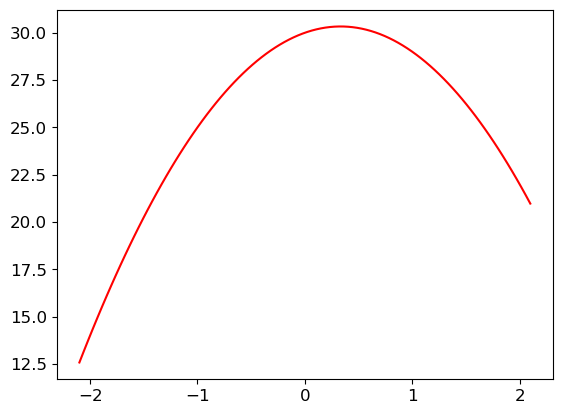

In [46]:
def f(x): return -3*x**2 + 2*x + 30

def plot_function(f, min=-2.1, max=2.1, color="r"):
    x = np.linspace(min,max, 100)[:,None]
    plt.plot(x, f(x), color)

plot_function(f)

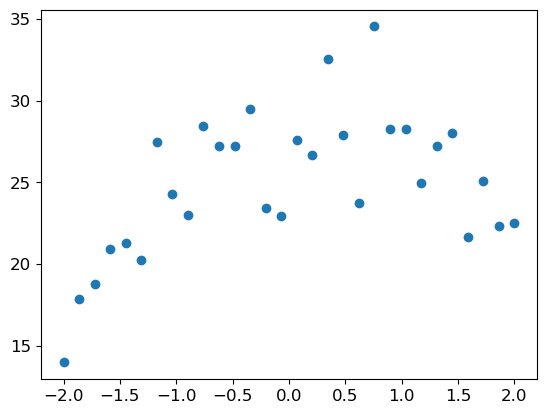

In [47]:
# This simply replicates the same behaviour for each run of this notebook (and your colab if you're following along)
from numpy.random import normal, seed, uniform
np.random.seed(42)

def noise(x,scale): return normal(scale=scale, size=x.shape)
def add_noise(x, mult, add): return x * (1+noise(x,mult)) + noise(x, add)

x = np.linspace(-2,2, num=30)[:,None]
y = add_noise(f(x), 0.1, 1.2)
plt.scatter(x,y)

These should look familiar from both Jeremy's notebook & the previous lessons where we create some quadratics and add noise, lets now show some over and underfitting of these data points.

As Jeremy mentions, we're going to create a function that fits polynomials of a given degree, a line being degree 1, a quadratic is degree 2, a cubic is degree 3, and so on. He recommends watching [this video](https://www.youtube.com/watch?v=ffLLmV4mZwU) as a refresher if this jargon is foreign to you. I don't remember the degrees of a polynomial so I'm going to watch this video now before I continue.

Ok, nice little watch, how long I retain this we'll see but I'm feeling good about polynomials being chains of terms with co-efficients and variables, thanks mathantics!

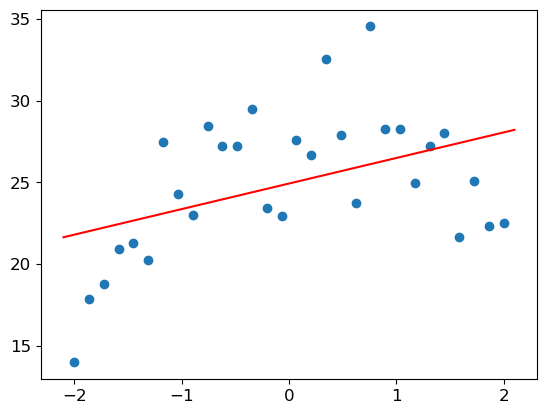

In [48]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

def plot_poly(degree):
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    model.fit(x,y)
    plt.scatter(x,y)
    plot_function(model.predict)
    

plot_poly(1)

Ok so looks like an "under" fit situation here, we're not really understanding the relationship between the data points and I don't think we understand how this data is shaped. Lets look at 10 degrees.

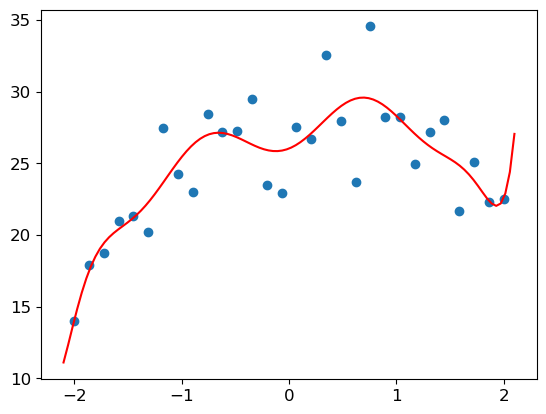

In [49]:
plot_poly(10)

Ok now we're "over" fitting as we're simply memorising and far too sensitive to the noise in the data, especially at the end where we completely invert the direction of the line and go back up, this is totally wrong!

Lets now get the right amount of degrees, which is 2 and also plot the underlying true function

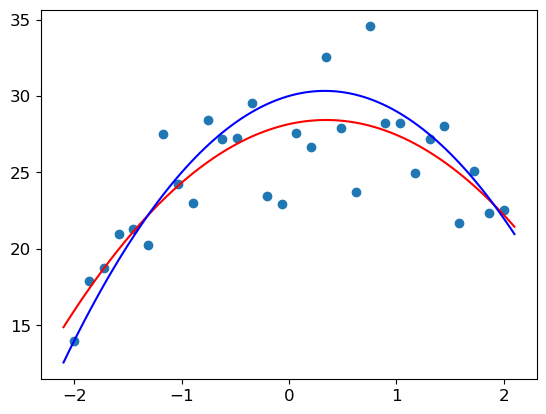

In [50]:
plot_poly(2)
plot_function(f, color="b")

Hey thats pretty cool, we're not far off here, we're properly understanding the relationship and estimating correctly the shape of the 'true' function. Of course we're off slightly since there's noise in the data but the approximation is excitingly close.

### Recognising Over/Under Fitting

This takes us back to our validation set, which is the tool we use to figure out if we're getting this relationship between under and over fitting in the sweet spot. This is a hold out of data from training that we use to see our model might generalise on 'unseen' data, we don't want to use the test set as thats only used at the very end of the process to check on 'unseen' unseen data. The problem arises from running many iterations and tests on your validation set, you're probably going to come across good random variables/parameters as well as slowly leak to your training process, what data is in the validation set which defeats the purpose of trying to see how well your model generalises on data it doesn't know from training. So we want to make decisions on a good validation set and hold out our test set for the very end of the process.

Transformers uses a "DatasetDict" for holding the training and validation sets. In this scenario we can simply slice apart a random 25% of our dataset for validation, but once again I'll post [Rachel Thomas's awesome writeup](https://www.fast.ai/posts/2017-11-13-validation-sets.html) on exactly this question of how to make a good validation set.

In [51]:
dds = tokeniser_dataset.train_test_split(0.25, seed=42)
dds

DatasetDict({
    train: Dataset({
        features: ['id', 'anchor', 'target', 'context', 'labels', 'input', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 27354
    })
    test: Dataset({
        features: ['id', 'anchor', 'target', 'context', 'labels', 'input', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9119
    })
})

Transformers uses the language of our 'validation' set being called 'test' set which actually isn't all that uncommon but we're being specific here so don't get confused between the two. Remember validation for informing our training process (but not used in the training process to learn from) and the final test set being an 'unseen' unseen set to holdout.

Lets modify our test dataset to include the same 'input' column that we made for our train dataset

In [52]:
evaluation_df["input"] = 'TEXT1: ' + evaluation_df.context + '; TEXT2: ' + evaluation_df.target + '; ANC1: ' + evaluation_df.anchor
evaluation_ds = Dataset.from_pandas(evaluation_df).map(tokenise_function,batched=True)

  0%|          | 0/1 [00:00<?, ?ba/s]

### Metrics & Correlation

